# Political Email Classification
Create a classification model using Natural Language Processing (NLP) and machine learning techniques to answer the question: Can a model predict the political ideology of a U.S. campaign or political organization from an email?


# Project Objective
One way political campaigns and organizations contact voters is through email. A model that predicts the political ideology (liberal-leaning or conservative-leaning) of an email can act as a tool for voters, political campaigns and organizations alike. 

Voters would benefit from this tool by gaining insight to the ideology of a political email they receive. This would be helpful in situations where a political organization, such as a PAC, or a political campaign do not clearly state their political agenda or party affiliation but are asking for financial contributions. 

Political campaigns and organizations would be able to use this tool as a part of their strategic planning for upcoming email campaigns. The model would allow campaigns and organizations to assess if the “tone” of their political-ideology is coming across, or target a specific type of voter. For example, if an organization's goal is to reach a particular type of voter they can assess if their email matches the recipient’s political ideology as a persuasion tactic. 


# Data
This project relies on data from Princeton Corpus of Political Emails and OpenSecrets.org. Explanation of the data and their value to the project are explained below. 

### Princeton Political Email Corpus
The Princeton Political Email Corpus contains 317,366 emails from over 3000 political campaigns and organizations in the 2020 election cycle in the US. Documentation for the corpus can be found [here](https://electionemails2020.org/assets/corpus_documentation_v1.0.pdf). This dataset is ideal for this classification problem as it contains a wide range of political emails. Emails from local, state-wide, and federal campaigns are found in the corpus along with political organizations with special interests.
1. `corpus`: [emails from the 2020 campaign cycle](https://electionemails2020.org/assets/corpus_documentation_v1.0.pdf) 

### OpenSecrets.org
OpenSecrets.org is a resource for campaign contributions and lobbying data. This data is necessary for this project in order to determine the political ideology of organizations who, unlike candidates, do not always have a declared party-affiliation. 

Data from OpenSecrets is imported in five tables:
1. `cands20`: high-level information about candidates for office
2. `cmtes20`: high-level information about organizaitons (such as PACs) 
3. `pacs`: records of contributions from organizations to candidates
4. `pac_other20`: records of contributions from one organzation to another 
5. `views`: [outside spending by viewpoint](https://www.opensecrets.org/outsidespending/summ.php?cycle=2020&chrt=V&disp=O&type=A) establishes a liberal, conservative, or other viewpoint based on spending. 

# Imports

In [2]:
#Standard Imports
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Data Cleaning 
import re
import string
from nltk.corpus import stopwords
from nltk import FreqDist

#modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from graphviz import *
from sklearn.linear_model import SGDClassifier

#Evaluation Imports
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            cohen_kappa_score, plot_confusion_matrix

#custom functions
from util import *

In [5]:
#emails
corpus = pd.read_csv('../data/corpus_v1.0.csv', low_memory=False)

In [6]:
corpus.head()

,from_name,from_address,subject,body_text,name,office_sought,party_affiliation,office_level,district_type,final_website,crawl_date,source,state,type,subtype,date,hour,day,uid_email,uid_inbox,incumbent
0,Kathleen Williams,info@kathleenformontana.com,Welcome to the team!,Thanks for joining the team! My name is Kathle...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2019-12-05,19,Thu,7182e4e604717330ecaf2699be61b200,08f13962c5b2090e32c902552a4ff634,No
1,Goal Update -- via Team Kathleen,info@kathleenformontana.com,Quickly closing in,We’re just 5 days away from our June 30th FEC ...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2020-06-25,14,Thu,00768081c0a2487180314475ed1121d1,08f13962c5b2090e32c902552a4ff634,No
2,Kathleen Williams,info@kathleenformontana.com,Welcome to the team!,Thanks for joining the team! My name is Kathle...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2019-12-03,19,Tue,54f56022dcd037ccb583f65a5668a073,08f13962c5b2090e32c902552a4ff634,No
3,Kathleen Williams,teamwilliams@kathleenformontana.com,Remembering Dr. King,Today we remember and honor the legacy of Dr. ...,Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2020-01-20,12,Mon,ff3fc8ba9b209b771a73ef831a4117b5,08f13962c5b2090e32c902552a4ff634,No
4,Jeff Allen,teamwilliams@kathleenformontana.com,We need to close the gap fast,"Here’s the truth,summer is the most difficult ...",Kathleen Williams,U.S. House Montana At-large District,Democratic Party,Federal,Congress,https://kathleenformontana.com/,12-02-2019,ballotpedia-campaign,NaN,NaN,NaN,2020-07-27,17,Mon,36e237928f238bf5fab8d5a5462d9a04,08f13962c5b2090e32c902552a4ff634,No


In [7]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317366 entries, 0 to 317365
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   from_name          317364 non-null  object
 1   from_address       317359 non-null  object
 2   subject            317351 non-null  object
 3   body_text          316790 non-null  object
 4   name               317366 non-null  object
 5   office_sought      198972 non-null  object
 6   party_affiliation  220390 non-null  object
 7   office_level       198972 non-null  object
 8   district_type      198972 non-null  object
 9   final_website      317366 non-null  object
 10  crawl_date         317366 non-null  object
 11  source             317366 non-null  object
 12  state              11175 non-null   object
 13  type               118394 non-null  object
 14  subtype            67441 non-null   object
 15  date               317366 non-null  object
 16  hour               3

# Establish Target
`party_affiliation` will be used as the target variable to classify the political ideology of an email. 96,976 emails are not labeled with a `party_affiliation`. If an email originated from an organization the organization it was not assigned a `party_affiliation` and one will need to be established for it.

In [8]:
#create target column
corpus['target'] = corpus['party_affiliation']

In [9]:
#number of target nulls
corpus['target'].isna().sum()

96976

In [10]:
corpus['target'].value_counts()

Democratic Party                              175234
Republican Party                               42208
Nonpartisan                                      653
Independent                                      556
Libertarian Party                                488
Working Families Party                           465
Green Party                                      381
Serve America Movement Party                     203
Maine Green Independent Party                     87
Independence Party                                48
United Utah Party                                 26
Constitution Party                                23
SAM Party of New York                              4
None                                               4
Alliance Party of South Carolina                   3
Unaffiliated                                       2
Democratic-Farmer-Labor Party of Minnesota         2
Reform Party                                       1
Unity Party                                   

In [11]:
#Sources: “ballotpedia-campaign” if the email was from a candidate running for office and “orgs” if the email was from an organization.
corpus['source'].value_counts()

ballotpedia-campaign    198972
orgs                    118394
Name: source, dtype: int64

118,394 emails in the corpus originate from organizations

# Addressing Missing Target Variables
Organizations Within the dataset are missing their target variable. The author of [this dissertation](https://repository.library.georgetown.edu/bitstream/handle/10822/1054947/Koch_georgetown_0076D_14174.pdf?sequence=1&isAllowed=y) was able to establish the political ideology (liberal or conservative) of political organzations using capaign finance records from OpenSecrets.org.  To address the missing target variables of the organizations in this dataset I will follow their methodology (pg. 19).

After reading in the OpenSecerets.org data: 
1. Establish a key to best reference between the Princeton Email Corpus and OpenSecrets.org data
2. Classify organization by `Party` given in OpenSecrets data
3. Classify organization by `Views` of the [organization's independent expenditures](https://www.opensecrets.org/outsidespending/summ.php?cycle=2020&disp=O&type=A&chrt=V). 
4. Classifiy organizaion by their industry code. 
5. Classify organization by the party of the recipients of thier contributions. 
6. Classify organization through informed research.

Steps 3-6 were established trough the methodology of the disscertation. 

### OpenSecrets.Org Data

In [12]:
#Candidates - cands20 import (Candidate Information)
cands20 = pd.read_csv('../data/cands20.txt', delimiter=",", quotechar="|", header=None)
cands20.columns = ['Cycle', 'FECCandID', 'CID', 'FirstLastP', 'Party', 'DistIDRunFor',
                   'DistIDCurr', 'CurrCand', 'CycleCand','CRPICO', 'RecipCode', 'NoPacs']

#FEC Committees - cmtes20 import (PACs and Candidate and Party Committees Information) 
cmtes20 = pd.read_csv('../data/cmtes20.txt', delimiter=",", quotechar="|", header=None)
cmtes20.columns = ['Cycle', 'CmteID', 'PACShort', 'Affiliate', 'Ultorg', 'RecipID', 
                   'RecipCode', 'FECCandID', 'Party', 'PrimCode', 'Source', 'Sensitive', 'Foreign', 'Active']

#PAC - pacs20 import (Contributions from PACs to Canidates)
pacs = pd.read_csv('../data/pacs20.txt', delimiter=",", quotechar="|", header=None)
pacs.columns = ['Cycle', 'FECRecNo', 'PACID', 'CID', 'Amount', 'Date', 'RealCode', 'Type', 'DI', 'FECCandID']

#Other - pac_other20 import (Contribution from PACs to other PACs or other organizations)
pac_other = pd.read_csv('../data/pac_other20.txt', delimiter=",", quotechar="|", header=None, low_memory=False)
pac_other.columns= ['Cycle', 'FECRecNo', 'Filerid', 'DonorCmte', 'ContribLendTrans', 'City', 'State', 'Zip',
            'FECOccEMP', 'Primcode', 'Date', 'Amount', 'RecipID', 'Party', 'OtherID', 'RecipCode', 'RecipPrimcode', 
            'Amend', 'Report', 'PG', 'Microfilm', 'Type', 'RealCode', 'Source']

#Views - OpenSecrets outsidespending by PAC with poltical view of PAC
views = pd.read_csv('../data/OpenSecret_PAC.csv', encoding = "ISO-8859-1")

In [13]:
#reformat lowercase letters and change blanks to NaN
cmtes20['Party'] = cmtes20['Party'].replace({'r': 'R', 'd':'D', ' ': np.nan})

#reformat lowercase letters and change blanks to NaN
pac_other['Party'] = pac_other['Party'].replace({'r': 'R', 'd':'D', ' ': np.nan})

In [19]:


def find_org_target(data, column):
    '''
    Finds organizations missing target variables. 
    Searches for organization within the named DataFrame and assigns 
    value from named column as target in the corpus Dataframe. 
    
    Input: data = name of Dataframe
           column = column to search in given DataFrame
    
    Output: target_variable_status()
    '''
    #find organizations missing target 
    orgs = [org for org in list(corpus['key'].loc[(corpus['source']=='orgs') 
                                & (corpus['target'].isna())].unique())]
    
    for org in orgs: 
        #determine if org appears
        if org in list(data['key'].unique()):
            #find org name in dataframe: 
            targ = data[column].loc[data['key']== org].values[0]

            #assign the party to the target variable: 
            corpus.loc[(corpus['key'] == org), 'target'] = targ

        else:
            continue

    return null_status()


### Step 1: Create a `key` for the organization names
* Use `name` from all the tables
* Standardize `name` by removing all special characters, spaces, and all letters to lowercase

In [20]:
corpus['key'] = corpus['name'].apply(lambda x: re.sub('\W+','', x.lower()))

cands20['key'] = cands20['FirstLastP'].apply(lambda x: re.sub('\W+','', x[:-4].lower())) #also removes party from name

cmtes20['key'] = cmtes20['PACShort'].apply(lambda x: re.sub('\W+','', x.lower()))

pac_other['key'] = pac_other['DonorCmte'].apply(lambda x: re.sub('\W+','', str(x))).str.lower()

views['key'] = views['Group'].apply(lambda x: re.sub('\W+','', x.lower()))

### Step 2: Classify organizaiton by `Party` in OpenSecrets `cmtes20` data

In [21]:
find_org_target(cmtes20, 'Party')

NameError: name 'null_status' is not defined

### Step 3: Classify organization by `Views` in OpenSecrets `views` data

In [14]:
find_org_target(views, 'View')

Target Nulls:  33743
Organizations without target: 177
Percentage of nulls classified: 0.65204792938459


### Step 4: Classify organizations by industry codes
* Organizations are assigned a code for their industry. [OpenSecrets explains the codes](https://www.opensecrets.org/resources/ftm/ch12p1.php) by "The coding system is hierarchical. At the very highest level, there are five super-categories: Business, Labor, Ideological/Single-Issue, Other and Unknown. Below that top level there are 13 "sectors," about 100 "industries" and in all, some 400 categories." For example, code J1200 is "Democratic/Liberal"
* I will categorize by the political/partisan industry codes. 

In [16]:
#bring in table to interpret 'PrimCode' in cmtes20
cat_codes = pd.read_csv('data/category_codes.csv')

#Create a dictionary of 'PrimCode' and the interpretable name
codes = list(cat_codes['Catcode']) 
cat_view = list(cat_codes['View'])
cat_dict = dict(zip(codes, cat_view))

def find_category_view(code):
    '''
    converts 'PrimCode' to interpretable category
    '''
    try: 
        category = cat_dict[code]
        return category
    except: 
        return np.NaN
        
#add category column along with category for each organization using the `PrimCode` 
cmtes20['category'] = cmtes20['PrimCode'].apply(lambda x: find_category_view(x))

In [17]:
find_org_target(cmtes20, 'category')

Target Nulls:  19389
Organizations without target: 99
Percentage of nulls classified: 0.8000639333443326


### Step 5: Classify organizations by contributions
Next I will search the organization's contributions to candidates, using the methodology described within the referenced research.

In order to accomplish this I will: 
1. Combine the pacs data frame of contributions with the cand20 data frame which contains the candidate's party
2. Iterate through the organizations without targets and locate their contributions within the dataframe
3. Calculate the rate of donation by party
4. Assign the target variable to the party that recieved the greatest rate of contributions

In [18]:
contributions = pacs.join(cands20.set_index('CID'), on='CID', how='inner', rsuffix='_cand')
contributions.head(2)

,Cycle,FECRecNo,PACID,CID,Amount,Date,RealCode,Type,DI,FECCandID,Cycle_cand,FECCandID_cand,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,key
0,2020,1011020200194684263,C00429241,N00033395,250,08/19/2019,H5100,24K,D,H2MI05119,2020,H2MI05119,Dan Kildee (D),D,MI05,MI05,Y,Y,I,DW,,dankildee
77,2020,1103120190194676681,C00429241,N00033395,100,03/25/2019,H5100,24K,D,H2MI05119,2020,H2MI05119,Dan Kildee (D),D,MI05,MI05,Y,Y,I,DW,,dankildee


In [19]:
#orgs that still need target
orgs = [org for org in list(corpus['key'].loc[(corpus['source']=='orgs') & (corpus['target'].isna())].unique())]

#Finds party affiliation of the candidates that an organization has contributed to. 
for org in orgs:
    
    if org in list(cmtes20['key'].unique()):

        #locate name in cmtes20 and find unique PACID
        pacid = cmtes20['CmteID'].loc[cmtes20['key'] == org].values[0]
        
        #locate all donations from PACID and and find rate of donations by party
        find_party = contributions['Party'].loc[contributions['PACID'] == pacid].value_counts(normalize=True)
                
        #calculate the target variable >65% assigned to same political party, <65% categorized as nonpartisan
        if len(find_party != 0):
            if find_party[0] > 0.65:
                corpus.loc[(corpus['key']== org), 'target'] = find_party.index[0]
                
            else:
                corpus.loc[(corpus['key']== org), 'target'] = 'Nonpartisan*'

In [20]:
target_variable_status()

Target Nulls:  7734
Organizations without target: 64
Percentage of nulls classified: 0.9202483088599241


I have reduced the number of nulls from 96976 to 7734, classifying 92% of the nulls. There are 64 organizations without an affiliation. Following the methodolgy of the research paper, I will do a manual check of the final organizations to find their affiliation.

### Step 6: Categorize remaining organizaitons through informed research
It is possible for there to be discrepancies between organzation names in the Princetion Email Corpus and OpenSecrets.For example, if an organization was misspelled. If an organization did not contribute to candidates or, did not have an FEC commitee ID number it would be missed by the previous steps. To capture the political affiliation of the final organzations I will conduct research trough OpenSecrets.org and manually assign a target variable.

In [21]:
corpus['name'].loc[corpus['target'].isna()].value_counts()

Let America Vote Victory Fund       4959
Catholicvote.Org Candidate Fund      353
The Action PAC                       297
Campaign For American Principles     234
Blue Future                          220
                                    ... 
Black Conservatives Fund               1
save our senate llc                    1
American Sovereignty PAC               1
CAUSES TO BELIEVE IN                   1
Students for Trump                     1
Name: name, Length: 66, dtype: int64

In [22]:
#Let America Vote Victory Fund: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00647529
corpus.loc[corpus['name']=='Let America Vote Victory Fund', 'target'] = 'Democratic/Liberal'

#Catholicvote.org: (https://www.opensecrets.org/outsidespending/detail.php?cmte=C00494021&cycle=2020)
corpus.loc[corpus['name']=='Catholicvote.Org Candidate Fund', 'target'] = 'Republican/Conservative'

#The Action PAC: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00569996
corpus.loc[corpus['name']=='The Action PAC', 'target'] = 'Republican/Conservative'

#American Principles: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00544387&cycle=2020
corpus.loc[corpus['name']=='Campaign For American Principles', 'target'] = 'Republican/Conservative'

#BlueFuture: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00659409&cycle=2020 
corpus.loc[corpus['name']=='Blue Future', 'target'] = 'Democratic/Liberal'

#Higer Heights: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00688200&cycle=2020 
corpus.loc[corpus['name']=='Higher Hieghts Political Fund', 'target'] = 'Democratic/Liberal'

#Colition for a Prosp: https://www.opensecrets.org/federal-lobbying/industries/summary?cycle=2020&id=N00 
corpus.loc[corpus['name']=='Coalition For A Prosperous America', 'target'] = 'Nonpartisan'

#JDCA PAC: https://www.opensecrets.org/outsidespending/detail.php?cmte=C00684969&cycle=2020
corpus.loc[corpus['name']=='Jdca PAC', 'target'] = 'Democratic/Liberal'

#Boundary Waters PAC: $0 https://www.opensecrets.org/outsidespending/detail.php?cmte=C00689406&cycle=2020
corpus.loc[corpus['name']=='Coalition For A Prosperous America', 'target'] = 'Nonpartisan'

#Common Purpose PAC: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00682211
corpus.loc[corpus['name']=='Common Purpose PAC', 'target'] = 'Democratic/Liberal'

#Personal PAC: unclear - mostly used by different donors as their "personal" PAC.

#Common Purpose PAC: https://www.opensecrets.org/political-action-committees-pacs/courage-campaign-super-pac/C00523498/independent-expenditures/2014
corpus.loc[corpus['name']=='Courage Campaign Super PAC', 'target'] = 'Democratic/Liberal'

#Clearpath Action: https://www.opensecrets.org/outsidespending/detail.php?cycle=2020&cmte=C00608943
corpus.loc[corpus['name']=='Clearpath Action, Inc', 'target'] = 'Republican/Conservative'

#Run Woemn Run: https://www.opensecrets.org/donor-lookup/results?cand=planned+parenthood&order=desc&page=7&sort=D
corpus.loc[corpus['name']=='Run Women Run', 'target'] = 'Democratic/Liberal'

#Monroe County For Bernie Sanders: https://www.opensecrets.org/search?q=monroe+county+for+bernie+sanders
corpus.loc[corpus['name']=='monroe county for bernie sanders', 'target'] = 'Democratic/Liberal'

#Patriot Voices PAC: https://www.opensecrets.org/political-action-committees-pacs/patriot-voices-pac/C00528307/summary/2020
corpus.loc[corpus['name']=='Patriot Voices PAC', 'target'] = 'Republican/Conservative'

In [23]:
target_variable_status()

Target Nulls:  865
Organizations without target: 50
Percentage of nulls classified: 0.9910802672826267


### Step 7: Evaluate Target and Drop Nulls
99% of the null values were classified from the steps above. I will drop the remaining nulls from the dataset. 

In [24]:
corpus.dropna(subset=['target'], inplace=True)

### Step 8: Political Ideology Categories
Now that each email has an established target, the target will be described in terms of politial ideology as 'liberal', 'center', or 'conservative' views. To correctly classify the categories I used the following sources to establish the categories: 
* [Third Parties in the United States](https://en.wikipedia.org/wiki/Third_party_(United_States)#Smaller_parties_by_ideology)
* [List of Political Parties in the United States with ideology](https://en.wikipedia.org/wiki/List_of_political_parties_in_the_United_States)

In [25]:
corpus['target'].value_counts()

Democratic Party                              175234
Republican Party                               42208
L                                              26997
D                                              25136
C                                              20987
Democratic/Liberal                             19373
Republican/Conservative                         1700
R                                               1409
Nonpartisan                                      802
Independent                                      556
Libertarian Party                                488
Working Families Party                           465
Green Party                                      381
Nonpartisan*                                     211
Serve America Movement Party                     203
X                                                148
Maine Green Independent Party                     87
Independence Party                                48
United Utah Party                             

In [26]:
target_dict = {}

target_dict['Liberal-Leaning'] = ['Democratic Party','L', 'D', 'Democratic/Liberal',  'Working Families Party', 'Green Party', 'Maine Green Independent Party', 'Democratic-Farmer-Labor Party of Minnesota', 'Citizens\' Party']
target_dict['Center'] = ['Nonpartisan', 'Independent', 'Nonpartisan*', 'X', 'Independence Party', 'Serve America Movement Party', 'United Utah Party', 'SAM Party of New York', 'None', 'Alliance Party of South Carolina', 'Unaffiliated','Third-Party', 'Unity Party', 'Reform Party']
target_dict['Conservative-Leaning'] = ['Republican Party', 'C', 'Republican/Conservative', 'R', 'Libertarian Party', 'Constitution Party']

In [27]:
def categorize_target(target): 
    '''
    Input current target, return political idology category.
    '''
    if target in target_dict['Liberal-Leaning']: 
        return 'Liberal'
    elif target in target_dict['Center']:
        return 'Center'
    elif target in target_dict['Conservative-Leaning']:
        return 'Conservative'

corpus['target'] = corpus['target'].apply(lambda x: categorize_target(x))

# Target EDA

What is the distribution of the target? 

In [28]:
corpus['target'].value_counts(normalize=True)

Liberal         0.782544
Conservative    0.211105
Center          0.006351
Name: target, dtype: float64

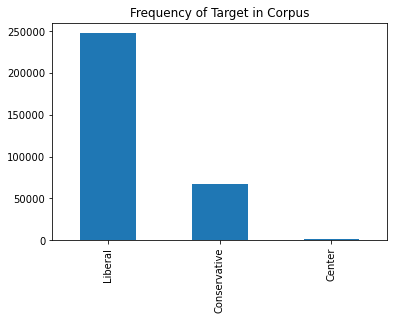

In [29]:
corpus['target'].value_counts().plot(kind='bar', title='Frequency of Target in Corpus');

There is quite an imbalance in the target within the Princeton Corpus of Poltiical Emails. Liberal viewpoints are represented almost 4 times more than conservative viewpoints and over 100 times more than 'center' viewpoints. 

How are the number of campaigns and organzations represented within each viewpoint? 

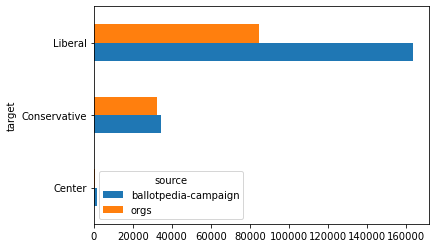

In [30]:
corpus.groupby('source').target.value_counts().unstack(0).plot.barh();

Within the liberal viewpoint more emails originate from campains than organziations. In the conservative viewpoint there is a balance between campains and organizations. 

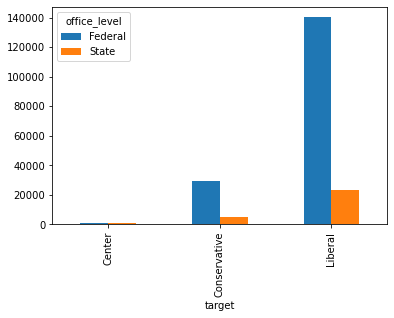

In [31]:
corpus.groupby('office_level').target.value_counts().unstack(0).plot.bar();

In [32]:
#Which elections for office sent the most email? 
corpus['office_sought'].value_counts()[:5]

President of the United States     8831
U.S. House New York District 18    7988
U.S. House Illinois District 3     6042
U.S. House Texas District 2        5935
U.S. House Oregon District 4       4905
Name: office_sought, dtype: int64

Most emails were sent from campaigns for President of the United States. In 2020 the Democratic Party's presidential primaries had the [largest field of presidential candidates since 1972](https://en.wikipedia.org/wiki/2020_Democratic_Party_presidential_primaries). Therefore, most emails in the corpus were from Presidential Campaigns, where most of the candidates contained liberal viewpoints. This also accounts for the large number of liberal views among emails seeking federal office. 

Who sent the most email overall? 

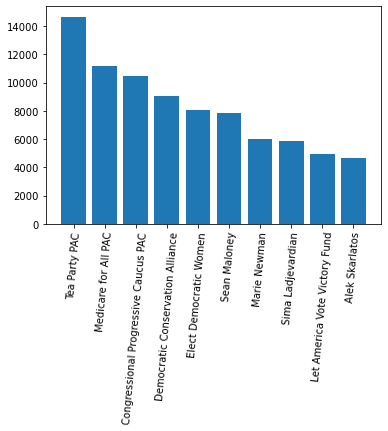

In [33]:
plt.bar(corpus['name'].value_counts().index[:10], corpus['name'].value_counts()[:10])
plt.xticks(rotation=85)
plt.show();

In [34]:
#create dataframe by viewpoint
liberal = corpus.loc[corpus['target']=='Liberal']
conservative = corpus.loc[corpus['target']=='Conservative']
center = corpus.loc[corpus['target']=='Center']

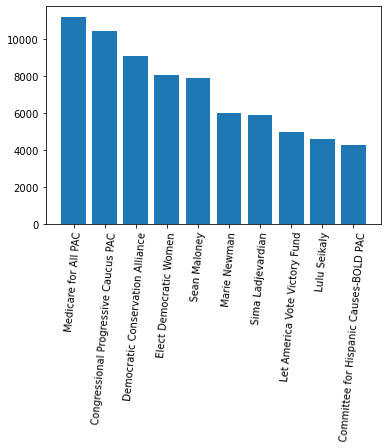

In [35]:
#liberal viewpoints most emails
plt.bar(liberal['name'].value_counts().index[:10], liberal['name'].value_counts()[:10])
plt.xticks(rotation=85)
plt.show();

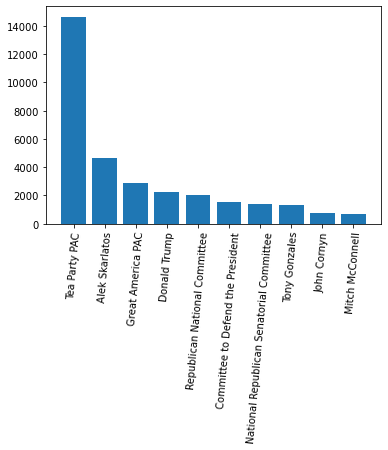

In [36]:
#conservative viewpoints most emails
plt.bar(conservative['name'].value_counts().index[:10], conservative['name'].value_counts()[:10])
plt.xticks(rotation=85)
plt.show();

In [37]:
conservative['name'].value_counts(normalize=True)[:5]

Tea Party PAC                    0.219262
Alek Skarlatos                   0.070044
Great America PAC                0.043478
Donald Trump                     0.033466
Republican National Committee    0.029933
Name: name, dtype: float64

Emails from Tea Party PAC contitutes approximately 22% of all emails from the 'conservative' viewpoint.

# Data Cleaning & Preprocessing

Preprocessing steps:
1. Remove all non-word characters, such as punctuation and numbers
2. Tokenize by whitespace, creating a 'tokens' column
3. Remove stopwords and stray single letters from tokens
4. Rejoin words as string for future vectorizing steps

In [38]:
#create text column
corpus['text'] = corpus['subject'] + " " + corpus['body_text'] 

#create dataframe of relevant columns for preprocessing
emails = corpus[['text', 'target']].copy()

In [39]:
#sample text before: 
emails['text'].iloc[4][:400]

'We need to close the gap fast Here’s the truth,summer is the most difficult fundraising season for any campaign, even though it’s\nKathleen Williams for Congress\nPlease be safe and follow CDC guidance during the coronavirus outbreak. As our country works through this difficult time, please join me in reaching out to those in need or who are feeling isolated - we are all in this together.\nHere’s the'

In [ ]:
#generate stopwords
stop_words = stopwords.words('english') + list(string.ascii_lowercase)

#use regex to remove all non-word characters
emails['clean2'] = emails['text'].apply(lambda x: re.sub(r'([\W\d_])+', ' ', str(x).lower()))

#create tokens and remove stopwords
emails['tokens'] = emails['clean2'].apply(lambda x: [word for word in x.split() if word not in stop_words])

#join tokens together for vectors
emails['clean2'] = emails['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
#sample text after
emails['clean2'].iloc[4][:400]

# Text Features EDA
## Length of Emails
I will explore the lengths of the email by target. Do different parties send longer/shorter emails than other parties? 

In [ ]:
#length before processing
emails['text_length'] = emails['text'].apply(lambda x: len(str(x)))

#length after processing
emails['clean_length'] = emails['clean2'].apply(lambda x: len(str(x)))

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.boxplot(data=emails[['target', 'text_length']],
            x='target',
            y='text_length',
            whis=25, 
            ax=ax[0]).set(title = 'Length of email by party', ylabel='Number of characters');

sns.boxplot(data=emails[['target', 'text_length']],
            x='target',
            y='text_length',
            showfliers=False, 
            ax=ax[1]).set(title = 'Length of email by party: without outliers', ylabel='Number of characters');

print(emails.groupby('target')['text_length'].describe().T)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.boxplot(data=emails[['target', 'clean_length']],
            x='target',
            y='clean_length',
            whis=25, 
            ax=ax[0]).set(title = 'Length of cleaned email by party', ylabel='Number of characters');

sns.boxplot(data=emails[['target', 'clean_length']],
            x='target',
            y='clean_length',
            showfliers=False, 
            ax=ax[1]).set(title = 'Length of cleaned email by party: without outliers', ylabel='Number of characters');

print(emails.groupby('target')['clean_length'].describe().T)

On average conservative emails are shorter than Liberal and Center/Nonpartisan emails. Liberal emails tend to be longer and contain more outliers as a group than the other two groups. The median lengths of emails are very similar between Center and Conservative parties, whereas the median length is approximately 200 characters longer in Liberal emails. 

## Words in Emails
I will explore what words appear in the corpus and within each of the target variables by finding the Frequency Distribution of all tokens and visualizing the frequency of words through bar graphs and wordclouds. 

### Vocabulary of Corpus

In [ ]:
#Explode tokens column to get all vocab in corpus
vocabulary = emails['tokens'].explode()

#Get frequency of vocab's appearance in corpus
freq_dist_vocab = FreqDist(vocabulary)

In [ ]:
def vocabulary_frequency(freq_dist, number, title): 
    '''
    Inputs: 
    * freq_dist= Frequency distribution of vocabulary in corpus
    * number = number, as integer, of the top number of vocabulary to retrun
    * title = title, as string, of the graph

    Returns: 
    * List and graph of top vocabulary in corpus
    '''
    # get tokens and frequency counts from freq_dist
    top = list(zip(*freq_dist.most_common(number)))
    tokens = top[0]
    counts = top[1]

    print(f'Top Tokens: {tokens[:number]}')

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)

In [ ]:
vocabulary_frequency(freq_dist_vocab, 20, 'Top 20 words in Political Emails')

In [ ]:
wordcloud = WordCloud(collocations=False, 
                      background_color="white", 
                      max_words=100)\
                      .generate(" ".join(vocabulary))

plt.figure(figsize=(10,10))
plt.title('Corpus Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

The top 20 words found within the Political Email Corpus, after traditional stopwords were removed, primarily include words such as 'click', 'like', and 'trump'. Interestingly words such as 'email', 'click', and 'unsubscribe' are heavily featured. This is likely due to the [US's CAN-SPAM Act](https://www.campaignmonitor.com/resources/knowledge-base/is-it-illegal-to-not-have-an-unsubscribe-link/) which require a clear message of how to opt out of emails in the future. Therefore variations of 'click here to unsubscribe' are common within the corpus. 

### Vocabulary within Targets

In [ ]:
#functions for generating freq_dist and wordclouds 
def get_vocab(target_name, token_column):
    '''
    Input: 
    * target_name = name of target, as string
    * token_column = column name to retrieve tokens 
    Returns: FreqDict for that target's vocabulary
    '''
    vocab = emails[token_column].loc[emails['target']==target_name].explode()
    freq_dist = FreqDist(vocab)
    return freq_dist

def get_wordcloud(freq_dist):
    '''
    Inputs: 
    *freq_dist: FreqDist of words
    *number: number for the max number of words in wordcloud
    '''
    wordcloud = WordCloud(collocations=False, 
                      background_color="white",
                      max_words=100)\
                      .generate_from_frequencies(freq_dist)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

In [ ]:
#Vocabulary for each party
for party in emails['target'].unique():
    print(f'Vocabulary for {party}')

    #create party freq_dict of vocab
    party_freq_dist = get_vocab(party, 'tokens') 

    #show top 25 vocab
    vocabulary_frequency(party_freq_dist, 25, party+' top vocabulary')

    get_wordcloud(party_freq_dist)

The three targets have different lists of top 25 words within their respective vocabularies. Some words appear within the top of all three target's vocabulary such as 'email', 'redacted', 'url', and 'alex'. I will pull a sample of emails to see why these words may be appearing frequently.

In [ ]:
sample_liberal_email = emails['text'].loc[emails['target']=='Liberal'].sample(1, random_state=40)
print('Sample Liberal Email: \n',sample_liberal_email.values[:300])

sample_conserv_email = emails['text'].loc[emails['target']=='Conservative'].sample(1, random_state=40)
print('\n\nSample Conservative Email: \n', sample_conserv_email.values[:300])

sample_center_email = emails['text'].loc[emails['target']=='Center'].sample(1, random_state=40)
print('\n\nSample Center Email: \n', sample_center_email.values[:300])

### Observations: 
* 'alex' is the name of the email recipient which is why it appears in the corpus so much. For this modling process to be transferable, it would be worth removing this word given that the names to email recipents will vary.
    * Addressing an email directly to the reciepient could be considered a marketing approach used more by one target than another. If this is the case, it could be worth feature engineering an element that shows a reciepient was addressed in the email. 
* [[URL REDACTED]] within emails is why 'url' and 'redacted' appear so frequently within the corpus vocabulary. The URLs were redacted by the Princeton Policial Corpus. Deploying a model for real-world application would not included these words. Therefore, it would to remove these words completely. 
    * 'url' and 'redacted' are featured more within some targets than others. Again, this could be a marketing strategy. Feature engineering how many links were present within an email, frequency of the word 'click', could reveal those practices. 
* "Democrat" is irregularly pluralized (e.g. Democrat, Democrats, Democratic Party unlike Republican, Republicans, Republican Party). Simple stemming would capture all versions of "Republican" but not all versions of "Democrat". 
* 'click' appears in a variety of ways within the sample emails: 'click here to unsubcribe', to "CLICK TO HELP GET OUR AD TO THE VOTERS", "Click here to claim your lawn sign". It may be worth investigating how model takes the word 'click' into consideration and removing, or feature engineering with it. 

## Adjustments to Vocabulary
Based on the observations trough EDA I will: 
1. Remove 'alex', 'url', 'redacted', 'email', 'emails', 'unsubscribe', and 'click'
2. Normalize 'democrat/democrats/democratic' by replacing with 'democrat'

In [ ]:
remove_words_sparse = ['alex', 'url', 'redacted', 'email', 'emails', 'unsubscribe', 'click']

emails['tokens_sparse'] = emails['tokens'].apply(lambda x: [word.replace('democrats', 'democrat')\
                                                 .replace('democratic', 'democrat') for word in x \
                                                 if word not in remove_words_sparse])

#join tokens for future vectorizers
emails['sparse_text'] = emails['tokens_sparse'].apply(lambda x: ' '.join(x))

#length of 'sparse_text' by characters
emails['sparse_length'] = emails['sparse_text'].apply(lambda x: len(str(x)))

## Vocabulary within target after adjustment
Explore the frequency of tokens within each target after adjustments from the previous step.

In [ ]:
#Vocabulary for each party
for party in emails['target'].unique():
    print(f'Vocabulary for {party}')

    #create party freq_dict of vocab
    party_freq_dist = get_vocab(party, 'tokens_sparse') 

    #show top 25 vocab
    vocabulary_frequency(party_freq_dist, 25, party+' top vocabulary')

    #create wordcloud
    get_wordcloud(party_freq_dist)

The top 25 words for each of the three target variables are different after adjustments. 

# Train Test Split
Conduct train, test, validation split early to prevent leakage. Stratify target within test and validation sets to account for imbalance

In [ ]:
data = emails[['sparse_text', 'target']].copy()    #condensed dataframe
data.columns = ['text', 'target']                  #easier column names
data.head(1)

In [ ]:
X = data['text'].astype(str)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.35, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size = 0.2, stratify=y_test)

#Encode target
le = LabelEncoder()
y_train_enc= le.fit_transform(y_train)
y_test_enc= le.transform(y_test)
y_val_enc= le.transform(y_val)
target_classes = le.classes_

print('Sizes: ')
print('X_train: ', {X_train.shape})
print('X_test: ', {X_test.shape})
print('X_val: ', {X_val.shape})

# Modeling
When approaching modeling I will use an iterative approach: model, evaluate, parameter tune, further modeling. When turning does not improve scores, I will adjust my the transformer or modeling methods. Use `sparse_text` and `target` to model.
## Baseline Model
Baseline is the average occurance of the target variables. Meaning, if a model was to guess the majority class it would be correct ~78% of the time. 

In [ ]:
y_train.value_counts(normalize=True)

## MultinomialNB with CountVectorizer

In [ ]:
#Create a MultinomialNB modeling pipeline with Count Vectorizer
ctvec_bayes_pipe = make_pipeline(CountVectorizer(),
                                 MultinomialNB())

#Fit model
ctvec_bayes_pipe.fit(X_train, y_train_enc)
                             
#Evaluate model
model_evaluation(ctvec_bayes_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes)

The model accurately identifies the idology of emails ~93.8% of the time. It is most accurate with identifying conservative ideology, followed by liberal, and center. Next I will tune parameters with the aim of improving the accuracy of the `center` targets.

In [ ]:
#Tune alpha parameter
ctvec_bayes_pipe.set_params(multinomialnb__alpha=0.5) 

#fit model
ctvec_bayes_pipe.fit(X_train, y_train_enc) 

#Evaluate
model_evaluation(ctvec_bayes_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes)

Tuning alpha to 0.5 decreased the overall accuracy score, but increased the accuracy of classifying `center` targets, which was my initial goal. This model is most likely to confuse `center` as `conservative`. The accuracy of the `liberal` target also decreased with more `liberal` emails being classified as `center` than before.


I conducted a Gridsearch on the piplein to find the `best_params_` as follows:
```
#create param grid to search
param_grid = {'countvectorizer__min_df': [1, 2, 5, 50],
          'countvectorizer__max_features': [None, 1000, 2000],
          'multinomialnb__alpha': [0.75, 1]}


#gridsearch and pring best_param results
search = GridSearchCV(ctvec_bayes_pipe, param_grid=param_grid)
search.fit(X_train, y_train_enc)
print(search.best_params_)
#{'countvectorizer__max_features': None, 'countvectorizer__min_df': 1, 'multinomialnb__alpha': 1}
```

The GridSearch produced the same results as the first model.

## DecisionTree with Count Vectorizer

In [ ]:
#Create a DecisionTree with CountVectorizer pipeline
tree_pipe = Pipeline([('vectorizer', CountVectorizer(min_df=0.02)),
                      ('tree', DecisionTreeClassifier(random_state=42, max_depth=10))])

#Fit to model
tree_pipe.fit(X_train, y_train_enc)

#Evaluate model
model_evaluation(tree_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes)

In [ ]:
#Plot Tree
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(tree_pipe['tree'], 
               feature_names = tree_pipe['vectorizer'].get_feature_names(), 
               class_names= target_classes, 
               filled = True)

plt.show();

In [ ]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

The first decison tree had an accuracy score of ~94%. It performed well in classifying `liberal` ideology of emails with 99% accuracy. It was less accurate when predicting `center`  and emails, they were only correctly predicted 5% of the time. Correctly predicting`conservative` emails with this decision tree were also less acurate than previous Naive Bayes models. 

A benifit of DecisionTrees is the ability to learn the feature importances the model used. The word 'privacy` was considered as the most important feature in this model. 

Moving forward in decision tree modeling, I will I will pass through a `class_weight` parameter with the goal of improving the accuracy of classifiying `center` and `conservative`

In [ ]:
#tune parameters
tree_pipe.set_params(tree__class_weight ='balanced')

#fit
tree_pipe.fit(X_train, y_train_enc)

model_evaluation(tree_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes)

Tuning the parameter `class_weights` to balanced had the desired effect of correctly predicting more `center` and `conservative` emails. This came at the cost of accuracy within the `liberal` and target. The accuracy score dropped to 79% which is only slightly better than our baseline (guessing) model. 

In [ ]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

'fewer' is considered the most important feature in this model, as compared to 'privacy' from the previous decision tree model. Interestingly, The top words in both cases are not intuative! In future modeling, I would like to include feature engineered variables into the decision tree. 

In the next phase of modling, I will tune the vectorizer rather than the decision tree. 

In [ ]:
#remove tree parameters and adjust vectorizer
tree_pipe.set_params(tree__max_depth=None, tree__class_weight=None,
                     vectorizer__min_df=0.05, vectorizer__max_df=0.99)

#Fit
tree_pipe.fit(X_train, y_train_enc)

#Evaluate
model_evaluation(tree_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes)

In [ ]:
plot_confusion_matrix(tree_pipe, X_test, y_test_enc, display_labels=target_classes) #no normalizatoin

This tree is the most accurate so far with a 96% accuracy score and Cohen's Kappa score of 0.89. It improves from previous model in its `center` and `conservative` target predictions while only suffering 1% decrease in accuracy of `liberal` email predictions. As with the first tree model, this model was most likely to make an error by classifying `center` emails as `liberal`. 

When observing the nonnormalized confusion matrix, the class imabalnce becomes apparent as there are so few `center` emails compared to `liberal` emails. While 7% of conservative emails are misidentified, compared to 32% of `center` emails, 7% of conservative emails represents a greater proportion of the corpus overall (1,422 emails compared to 181 emails). 

In [ ]:
#Finding the feature importances
features = dict(zip(tree_pipe['vectorizer'].get_feature_names(), tree_pipe['tree'].feature_importances_))

pd.DataFrame.from_dict(features, orient='index').sort_values(by=0, ascending=False).head(5)

## Stochastic Gradient Descent (SGD)

In [ ]:
#Make SGDC pipline
sgdc_pipe = make_pipeline(CountVectorizer(),
                          SGDClassifier())

#Fit
sgdc_pipe.fit(X_train, y_train_enc)

#Evaluation
model_evaluation(sgdc_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes)

In [ ]:
#Finding the feature importances
features = sgdc_pipe['countvectorizer'].get_feature_names()
coefficients = sgdc_pipe['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

This model performed very well! With 99% accuracy! The model accurately classifyies both `liberal` and `conservative` emails, and captures a majority of the `center` ideology emails. The accuracy of each target corresponds with the proportion of the target within the dataset (liberal is the highest accuracy and the most observed label in the dataset, vice versa with center.) Perhaps the imbalance within the target partially contributes to the results. In the next model I will tune the class_weights of the SGDClassifier to 'balanced'.

In [ ]:
#Make SGDC2 pipline
sgdc_pipe = make_pipeline(CountVectorizer(),
                          SGDClassifier(class_weight='balanced',
                                        random_state=42))

#Fit
sgdc_pipe.fit(X_train, y_train_enc)

#Evaluation
model_evaluation(sgdc_pipe, X_train, y_train_enc, X_test, y_test_enc, target_classes)

In [ ]:
plot_confusion_matrix(sgdc_pipe, X_test, y_test_enc, display_labels=target_classes) #not normalized

In [ ]:
#Finding the feature importances
features = sgdc_pipe['countvectorizer'].get_feature_names()
coefficients = sgdc_pipe['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

So far, the SGDClassifier models are accurate on training and testing data. However, after inspecting the important features of the model many are names which may not be generalizeable to future classification situations and impact how this model performs on unseen data. 

##  Binary target with Stochastic Gradient Descent
In this series of modeling, I will explore if the features of a SGDClassifer model would be more generalizable using a binary target. I will train/test/split the data again after creating a binary target then model with SGDClassifier and CountVectorizer.

In [ ]:
#create new dataframe of only Liberal and Conservative emails
data2 = data.loc[data['target'] != "Center"].copy() 

#reproduce train/test/split with binary target
X2 = data2['text'].astype(str)
y2 = data2['target']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, test_size=0.35, stratify=y2)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_test2, y_test2, random_state=42, test_size = 0.2, stratify=y_test2)

#encode binary target
y_train_enc2= le.fit_transform(y_train2)
y_test_enc2= le.transform(y_test2)
y_val_enc2= le.transform(y_val2)

target_classes = le.classes_ #keeping this as 'target_classes' for use in model_evaluation function

In [ ]:
#Make SGDC pipline for binary target. Use same parameters as before
sgdc_binary = make_pipeline(CountVectorizer(),
                           SGDClassifier(random_state=42))

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
model_evaluation(sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2, target_classes)

In [ ]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

The top features of this list are different from the multi-class target. It contains fewer names and more politically-charged words. 

In the next model I will tune the vectorizer to reduce the demensionality of the words. 

In [ ]:
#Set parameter
sgdc_binary.set_params(countvectorizer__min_df=0.02, countvectorizer__max_df=0.99)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
model_evaluation(sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2, target_classes)

In [ ]:
#Finding the feature importances
features = sgdc_binary['countvectorizer'].get_feature_names()
coefficients = sgdc_binary['sgdclassifier'].coef_.flatten()

#zip features and coefficients to form a dataframe
feature_importances = pd.DataFrame(zip(features, coefficients), columns=['features', 'values'])

#find absolute value of values
feature_importances['abs_val'] = feature_importances['values'].apply(lambda x: abs(x))

#sort values
feature_importances.sort_values(by='abs_val', ascending=False)[:20]

In [ ]:
print(f'{len(feature_importances)} features in sgdc_binary2')

Reducing the number of features decreased the accuracy score from 99% to 97%. The model continues to perform well and better than the baseline. For the next model I will tune the CountVectorizer to allow for more features with the aim of increasing the accuracy score. 

In [ ]:
#adjust max_df parameter
sgdc_binary.set_params(countvectorizer__max_df=1.0, countvectorizer__min_df=0.01)

#Fit
sgdc_binary.fit(X_train2, y_train_enc2)

#Evaluation
model_evaluation(sgdc_binary, X_train2, y_train_enc2, X_test2, y_test_enc2, target_classes)

# Final Model
 The best choice for a reliable model which will perform well on unseen data is a model which uses a CoundVectorizer and Stochastic Gradient Descent Classifier to classify a binary target (liberal or conservative). These models consistently produced high accuracy scores, and high Cohen's Kappa coefficient. Futhermore these models used features that could generalize to real-world emails outside of this political corpus. 

To assess these observations, I will evaluate the model on a final holdout validation dataset.

In [ ]:
final_model = make_pipeline(CountVectorizer(min_df=0.01),
                            SGDClassifier(random_state=42))

#Fit
final_model.fit(X_train2, y_train_enc2)

#Evaluation
model_evaluation(final_model, X_train2, y_train_enc2, X_val2, y_val_enc2, target_classes)

This model performed as expected on a holdout set of data. Achieveing 98% accuracy and ~0.94 Cohen's Kappa coefficient. These metrics are chosen to evaluate this model because the objective of creating this classifer is accuracy. In this situation a false positive (predicting a email as Liberal email when it was in fact a Conservative email) is not more or less preferable to a false negative (predciting a email as Conservative when it was in fact Liberal). 

Accuracy was the most important evaluation measure along with [Cohen's Kappa metric](https://en.wikipedia.org/wiki/Cohen%27s_kappa) to evaluate the agreement between the true and predicted targets. This model scored 0.94, [scores above .8 are generally considered good agreement](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-kappa). 

# Conclusion
The stated goal of this process was to create a classification model using Natural Language Processing (NLP) and machine learning techniques to answer the question: Can a model predict the political ideology of a U.S. campaign or political organization from an email? 

With 98% accuracy this model classifed the political ideology (liberal or conservative) of an email.

Using this model, email recipeients would to gain a tool for transparency to classify emails from political organizations that did not have a stated political affiliation. On the other hand, politial organzations and candidates could use this tool to assess the their outgoing email's political-ideology. This could help to strategically plan emails to appeal to target voters or produce emails that align  with their politial ideology. 

There are limiations to the model. As this model was only trained on political emails from the United States 2020 Election Cycle it is only applicable to emails for recent U.S. politics. The model may not be reliable long-term. To create a more lasting model, emails from past election cycles would be useful to include in the corpus. Building onto this corpus could also generate a more lasting model. 

There are also areas to improve this model. This model only considered the email's text to make a classification. Including additional variables within the modeling process could reveal more underlying features for classification. Elements to consider are length of email, time of day/month/eleciton cycle email was recieved, number of links within an email, if the email is addresed to a recipeient directly or not. These additional email features could share insights to the classification problem. 